In [1]:
import time
import json
import pickle
import itertools
import numpy as np
import pandas as pd
import xgboost as xgb
from sklearn.metrics import roc_auc_score, accuracy_score
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from hyperopt import STATUS_OK, Trials, fmin, hp, tpe

In [2]:
path = 'data/nasty_data.fea'
nasty = pd.read_feather(path).sample(frac=.1)

In [3]:
with open('data/strikezone_model.pkl', 'rb') as f:
    sz_model = pickle.load(f)

### Prepare data

In [4]:
swing_map = {
    'ball': 0,
    'foul': 1,
    'called_strike': 0,
    'swinging_strike': 1,
    'hit_into_play': 1,
    'missed_bunt': 1,
    'blocked_ball': 0,
    'foul_tip': 1,
    'swinging_strike_blocked': 1,
    'foul_bunt': 1,
    'intent_ball': 0,
    'hit_by_pitch': 0,
    'bunt_foul_tip': 1,
    'pitchout': 0,
    'swinging_pitchout': 1}

nasty['swing'] = nasty.description.map(swing_map)

nasty['swinging_strike'] = nasty.description.map(
    {'swinging_strike': 1, 'swinging_strike_blocked': 1})

nasty.swinging_strike = nasty.swinging_strike.fillna(0)


In [5]:
# subset to pitches that are swings
nasty = nasty.loc[nasty.swing == 1].reset_index(drop=True)

In [6]:
# create probabalistic strikezone
sz_model_cols = ['effective_speed', 'pfx_x', 'pfx_z', 'vx0', 'vz0', 'ax',
                 'az', 'release_pos_x', 'release_pos_z']

nasty = nasty.dropna(subset=sz_model_cols).reset_index(drop=True)

X_sz = np.array(nasty[sz_model_cols])
nasty['strikezone_prob'] = sz_model.predict(X_sz)

In [7]:
# define label and features
label_col = 'swinging_strike'
x_cols = ['release_spin_rate', 'effective_speed', 'pfx_x', 'strikezone_prob',
          'pfx_z', 'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'spin_axis']

nasty = nasty.dropna(subset=[label_col] + x_cols )\
    .reset_index(drop=True)

In [8]:
# prepare X and y
# ohe = OneHotEncoder(sparse=False)
# column_transformer = ColumnTransformer(
#     transformers=[('ohe', ohe, ['pitch_type'])],
#     remainder='passthrough')

y = np.array(nasty[label_col])
X = np.array(nasty[x_cols])

In [9]:
X_train, X_test, y_train, y_test = train_test_split(X, y)

print(f'X_train: {len(X_train)}, y_train: {len(y_train)}')
print(f'X_test: {len(X_test)}, y_test: {len(y_test)}')

X_train: 134162, y_train: 134162
X_test: 44721, y_test: 44721


### Parameter grid

In [10]:
param_space = {'max_depth': hp.quniform("max_depth", 3, 10, 1),
               'gamma': hp.uniform('gamma', 0, 14),
               'learning_rate': hp.uniform('learning_rate', 0, 1),
               'reg_alpha': hp.uniform('reg_alpha', 0, 1),
               'reg_lambda': hp.quniform('reg_lambda', 0, 10, 1),
               'colsample_bytree': hp.uniform('colsample_bytree', 0.3, 1),
               'min_child_weight': hp.quniform('min_child_weight', 0, 10, 1),
               'n_estimators': hp.quniform('n_estimators', 100, 1000, 10)
               }

evaluation = [(X_train, y_train), (X_test, y_test)]


def objective(space):
    model = xgb.XGBRegressor(objective='binary:logistic',
                             eval_metric='auc',
                             n_estimators=int(space['n_estimators']),
                             learning_rate=space['learning_rate'],
                             max_depth=int(space['max_depth']),
                             gamma=space['gamma'],
                             reg_lambda=space['reg_lambda'],
                             reg_alpha=space['reg_alpha'],
                             min_child_weight=int(space['min_child_weight']),
                             colsample_bytree=space['colsample_bytree']
                             )

    model.fit(X_train, y_train, eval_set=evaluation, eval_metric='auc',
              early_stopping_rounds=10, verbose=False)

    pred = model.predict(X_test, iteration_range=(0, model.best_iteration + 1))
    score = roc_auc_score(y_test, pred)

    return {'loss': -score, 'status': STATUS_OK}


In [11]:
trials = Trials()
best_hyperparams = fmin(fn=objective,
                        space=param_space,
                        algo=tpe.suggest,
                        max_evals=100,
                        trials=trials)

100%|██████████| 100/100 [35:38<00:00, 21.39s/trial, best loss: -0.7438111849838251]


In [12]:
model = xgb.XGBRegressor(objective='binary:logistic',
                         use_label_encoder=False,
                         eval_metric='auc',
                         n_estimators=int(best_hyperparams['n_estimators']),
                         max_depth=int(best_hyperparams['max_depth']),
                         gamma=best_hyperparams['gamma'],
                         reg_lambda=best_hyperparams['reg_lambda'],
                         reg_alpha=best_hyperparams['reg_alpha'],
                         min_child_weight=int(best_hyperparams['min_child_weight']),
                         colsample_bytree=best_hyperparams['colsample_bytree'])

model.fit(X_train, y_train, eval_set=evaluation, eval_metric='auc', verbose=False)


XGBRegressor(base_score=0.5, booster='gbtree', colsample_bylevel=1,
             colsample_bynode=1, colsample_bytree=0.7922127231363536,
             enable_categorical=False, eval_metric='auc',
             gamma=8.334691455051843, gpu_id=-1, importance_type=None,
             interaction_constraints='', learning_rate=0.300000012,
             max_delta_step=0, max_depth=10, min_child_weight=10, missing=nan,
             monotone_constraints='()', n_estimators=370, n_jobs=8,
             num_parallel_tree=1, objective='binary:logistic', predictor='auto',
             random_state=0, reg_alpha=0.7812470300115504, reg_lambda=9.0,
             scale_pos_weight=1, subsample=1, tree_method='exact',
             use_label_encoder=False, validate_parameters=1, ...)

<AxesSubplot:title={'center':'Feature importance'}, xlabel='F score', ylabel='Features'>

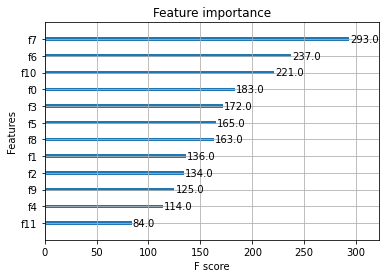

In [13]:
xgb.plot_importance(model)

In [ ]:
with open('data/model_swingmiss.pkl', 'wb') as f:
    pickle.dump(model, f)
with open('data/best_hp_swingmiss.pkl', 'wb') as f:
    pickle.dump(best_hyperparams, f)

In [14]:
preds = model.predict(X_test)
accuracy = accuracy_score(y_test, preds.round(0))
auc = roc_auc_score(y_test, preds)

print(f'Percent swing and miss: {round(sum(y_test == 1) / len(y_test)*100, 2)}%')
print(f'Swing and miss classification accuracy: {(np.take(preds.round(0), np.nonzero(np.array(y_test))).sum()/np.take(np.array(y_test), np.nonzero(np.array(y_test))).sum() * 100).round(2)}%')
print(f'Total classification accuracy: {accuracy.round(4)*100}%')
print(f'ROC AUC score: {auc.round(3)}')

Percent swing and miss: 22.72%
Swing and miss classification accuracy: 25.47%
Total classification accuracy: 80.25999999999999%
ROC AUC score: 0.74
